### Packages

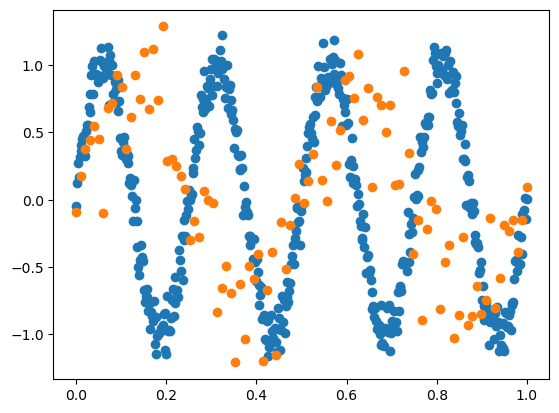

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Generate samples for class 0
t0 = np.linspace(0, 1, num=500)
x0 = 0.5*np.sin(np.pi*8*t0) + 0.5*np.sin(1*np.pi*8*t0) + np.random.normal(0, 0.1, size=len(t0))
y0 = np.zeros(len(t0))

# Generate samples for class 1
t1 = np.linspace(0, 1, num=100)
x1 = 0.8*np.sin(2*np.pi*2*t1) + np.random.normal(0, 0.3, size=len(t1))
y1 = np.ones(len(t1))

# Combine the samples
x = np.concatenate((np.column_stack((x0, y0)), np.column_stack((x1, y1))))

# Shuffle the samples
np.random.shuffle(x)

# Plot the samples
plt.scatter(t0, x0)
plt.scatter(t1, x1)
plt.show()


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/oldrain123/imbalanced_c2st/')

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.stats import norm

from model import c2st_nn_fit
from utils import GenerateData, MatConvert

In [84]:
data_generator = GenerateData(100, 1)
data = data_generator.mixn_mixn(sigma0=0.8, sigma1=0.5, delta=0.1)
X = data[:, 0]
y = data[:, 1]

100
100


### Simulations

In [78]:
# Setup seeds 
np.random.seed(1203)
torch.manual_seed(1203)
torch.cuda.manual_seed(1203)

torch.backends.cudnn.deterministic = True
is_cuda = True

# Setup for all experiments 
dtype = torch.float
device = torch.device("cuda:0")
alpha = 0.05 # test threshold 
ir_list = [1,3,5,7,9] # imbalance ratio
x_in = 2 # number of neurons in the input layer (dimension of data)
H = 50 # number of neurons in the hidden layer
x_out = 2 # number of neurons in the output layer 
K = 100 # number of experiments
n1 = 300 # size of minority samples

tb_logger = SummaryWriter(log_dir = "/home/oldrain123/log")

NameError: name 'LeNet' is not defined

In [75]:
# For each n in n_list, train deep kernel and run two-sample test
stats_a_dict = {}
stats_d_dict = {}
stats_p_dict = {}

acc_opt_cuts = []
pwr_opt_cuts = []

a_powers = {}
d_powers = {}
p_powers = {}

for r in ir_list:
    N1 = n1 * r
    N2 = n1
    batch_size = N1+N2 # not using batch 
    n_epoch_c2st = 2000
    
    # Repeat experiments K times (K = 10) and report average test powers
    stats_a_nn = []
    stats_d_nn = []
    stats_p_nn = []
    
    for kk in range(K):        
        np.random.seed(seed=112*kk + 1 + N1)
        data_generator = GenerateData(n_minor=N2, ir=r)
        data = data_generator.beta_beta(mu0=1.6, cov0=1, mu1=4, cov1=1, dim=1)
        S = data[:, 0].reshape(-1,1)
        S = MatConvert(S, device, dtype)
        y = MatConvert(data[:, 1], device, dtype)
        # y = (torch.cat((torch.zeros(N1, 1), torch.ones(N2, 1)), 0)).squeeze(1).to(device, dtype).long()
        
        cutvals = np.arange(start=0.001, stop=0.999, step = 0.001)
        acc_opt_cut, pwr_opt_cut = c2st_nn_fit(S, y, x_in, H, x_out, cutvals, 0.01, n_epoch_c2st, batch_size, device, dtype, validation=True)
        acc_opt_cuts.append(acc_opt_cut)
        pwr_opt_cuts.append(pwr_opt_cut)
        stat_a, stat_d, stat_p = c2st_nn_fit(S, y, x_in, H, x_out, cutvals, 0.01, n_epoch_c2st, batch_size, device, dtype, validation=False, acc_opt_cut=acc_opt_cut, pwr_opt_cut=pwr_opt_cut)
        
        # statistics
        stats_a_nn.append(stat_a)
        stats_d_nn.append(stat_d)
        stats_p_nn.append(stat_p)
        tb_logger.add_scalar('sims/stat_a', stat_a, global_step = kk)
        tb_logger.add_scalar('sims/stat_d', stat_d, global_step = kk)
        tb_logger.add_scalar('sims/stat_p', stat_p, global_step = kk)

    stats_a_dict[r] = stats_a_nn
    stats_d_dict[r] = stats_d_nn
    stats_p_dict[r] = stats_p_nn
    # power
    cr = norm.ppf(1-alpha)
    a_pwr = np.mean((stats_a_nn > cr))
    d_pwr = np.mean((stats_d_nn > cr))
    p_pwr = np.mean((stats_p_nn > cr))
    tb_logger.add_scalar('N_vs_N/a_pwr', a_pwr, global_step = r)
    tb_logger.add_scalar('N_vs_N/d_pwr', d_pwr, global_step = r)
    tb_logger.add_scalar('N_vs_N/p_pwr', p_pwr, global_step = r)

    a_powers[r] = a_pwr
    d_powers[r] = d_pwr
    p_powers[r] = p_pwr
    print("Accuracy Power: {}".format(a_pwr), '\t', "Default Power: {}".format(d_pwr), '\t', "Power Power: {}".format(p_pwr))
    print("="*50)

Epochs: 0	Training Binary CE Loss: 0.8632	Validation Binary CE Loss: 0.863	Training Accuracy: 0.5	Validation Accuracy: 0.5
Epochs: 100	Training Binary CE Loss: 0.6931	Validation Binary CE Loss: 0.6931	Training Accuracy: 0.5	Validation Accuracy: 0.5
Epochs: 200	Training Binary CE Loss: 0.693	Validation Binary CE Loss: 0.693	Training Accuracy: 0.5	Validation Accuracy: 0.5
Epochs: 300	Training Binary CE Loss: 0.6611	Validation Binary CE Loss: 0.667	Training Accuracy: 0.6733	Validation Accuracy: 0.6933
Epochs: 400	Training Binary CE Loss: 0.5842	Validation Binary CE Loss: 0.6202	Training Accuracy: 0.68	Validation Accuracy: 0.6667
Epochs: 500	Training Binary CE Loss: 0.5841	Validation Binary CE Loss: 0.6202	Training Accuracy: 0.68	Validation Accuracy: 0.66
Epochs: 600	Training Binary CE Loss: 0.5839	Validation Binary CE Loss: 0.6204	Training Accuracy: 0.68	Validation Accuracy: 0.66
Epochs: 700	Training Binary CE Loss: 0.5833	Validation Binary CE Loss: 0.623	Training Accuracy: 0.68	Validatio

KeyboardInterrupt: 

In [ ]:
ir_list

In [ ]:
a_powers = {1:0.18, 3:0.02, 5:0.04, 7:0.00, 9:0.0}
p_powers = {1:0.16, 3:0.18, 5:0.34, 7:0.42, 9:0.38}
d_powers = {1:0.34, 3:0.14, 5:0.08, 7:0.1, 9:0.2}

import seaborn as sns
import matplotlib.pyplot as plt

data_a = []
data_p = []
data_d = []
for r in ir_list:
    data_a.append({'imbalance_ratio': r, 'power': a_powers[r]})
    data_p.append({'imbalance_ratio': r, 'power': p_powers[r]})
    data_d.append({'imbalance_ratio': r, 'power': d_powers[r]})
    
        
df_a = pd.DataFrame(data_a)
df_p = pd.DataFrame(data_p)
df_d = pd.DataFrame(data_d)
# Create the plotNo
sns.set_style("whitegrid")
sns.lineplot(data=df_a, x="imbalance_ratio", y="power", label='Max Acc')
sns.lineplot(data=df_p, x="imbalance_ratio", y="power", label='Max Pwr')
sns.lineplot(data=df_d, x="imbalance_ratio", y="power", label='Default')

# Add axis labels and a title
plt.xlabel("Imbalance Ratio")
plt.ylabel("Power")
plt.title("Mean Differnece between Normal")
plt.legend()
# Show the plot
plt.show()

In [ ]:
# For each n in n_list, train deep kernel and run two-sample test
stats_a_dict = {}
stats_d_dict = {}
stats_p_dict = {}

acc_opt_cuts = []
pwr_opt_cuts = []

a_powers = {}
d_powers = {}
p_powers = {}

for r in ir_list:
    np.random.seed(1203)
    N1 = n1 * r
    N2 = n1
    batch_size = N1 + N2 # not using batch 
    n_epoch_c2st = 1000
    
    # Repeat experiments K times (K = 10) and report average test powers
    stats_a = []
    stats_d = []
    stats_p = []
    
    for kk in range(K):
        print('='*100)
        print("\t\t\t\tImbalance Ratio: {}".format(int(N1/N2)))
        print(f"\t\t\t\tExperiments{kk+1}")
        print('='*100)
        # Generate Blob-D
        np.random.seed(seed=112*kk + 1 + N1)
        s1, s2 = sample_blobs_Q(N1, N2, sigma_mx2)
        
        if kk == 0:
            s1_o = s1
            s2_o = s2
        
        S = np.concatenate((s1,s2), axis=0)
        S = MatConvert(S, device, dtype)
        
        # Train C2ST-L
        np.random.seed(seed=1203)
        torch.manual_seed(1203)
        torch.cuda.manual_seed(1203)
        y = (torch.cat((torch.zeros(N1, 1), torch.ones(N2, 1)), 0)).squeeze(1).to(device, dtype).long()
        cutvals = np.linspace(0.001, 0.999, 1000)
        pred, tau0, tau1, stat_c2st = c2st_nn_power(S, y, x_in, H, x_out, 0.01, n_epoch_c2st, batch_size, device, dtype)

In [ ]:
# For each n in n_list, train deep kernel and run two-sample test

stats = {}
powers = []
for n in n_list:
    np.random.seed(12203)
    torch.manual_seed(12203)
    torch.cuda.manual_seed(12203)
    N1 = 30 * n
    N2 = 300
    results = np.zeros([5, K])
    J_star_adp = np.zeros([K, n_epoch])
    batch_size = N1 + N2 
    n_epoch_c2st = 500
    
    # Repeat experiments K times (K = 10) and report average test power 
    stat = []
    for kk in range(K):
        print("Imbalance Ratio: {}".format(N1/N2))
        print(f"{kk+1} Experiments...")
        
        # Generate Blob-D
        np.random.seed(seed=112*kk + 1 + n)
        s1, s2 = sample_blobs_Q(N1, N2, sigma_mx2)
        
        if kk == 0:
            s1_o = s1
            s2_o = s2
        
        S = np.concatenate((s1,s2), axis=0)
        S = MatConvert(S, device, dtype)
        
        # Train C2ST-L
        np.random.seed(seed=12203)
        torch.manual_seed(12203)
        torch.cuda.manual_seed(12203)
        y = (torch.cat((torch.zeros(N1, 1), torch.ones(N2, 1)), 0)).squeeze(1).to(device, dtype).long()
        pred, tau0, tau1, stat_c2st_l, model_c2st_l, w_c2st_l, b_c2st_l = C2ST_NN_power(S, y, N1, x_in, H, x_out, 0.0005, 
                                                                          n_epoch_c2st, batch_size, device, dtype)
        # statistics
        stat.append(stat_c2st_l)
        print(pred.unique(return_counts=True))
        print(f"tau0: {tau0} \t tau1: {tau1} ", end='\t')
        print("Stats: {}".format(stat_c2st_l))
        stats[n] = stat
        
    # power
    pwr = len([i for i in stats[n] if i > (1-norm.ppf(alpha))]) / len(stats[n])
    powers.append(pwr)
    print("Power: {}".format(pwr))
    print("="*50)

In [ ]:
stats

In [ ]:
tau1

In [ ]:
stat_c2st_l

In [ ]:
pred.unique(return_counts=True)

In [ ]:
stats

In [ ]:
batch_size = 32

df = sample_blobs_Q(500, 500, sigma_mx2)

In [ ]:
# Generate data
data = sample_blobs_Q(n0=500, n1=500, sigma_mx_2=sigma_mx2)

# Split data into training and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Convert data to PyTorch tensors
train_x = torch.tensor(train_data.iloc[:, :-1].values, dtype=torch.float32)
train_y = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.int64)
test_x = torch.tensor(test_data.iloc[:, :-1].values, dtype=torch.float32)
test_y = torch.tensor(test_data.iloc[:, -1].values, dtype=torch.int64)

# Define the LeNet model
model = LeNet()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Shuffle the training data
    indices = torch.randperm(train_x.shape[0])
    train_x = train_x[indices]
    train_y = train_y[indices]
    
    # Train the model for one epoch
    model.train()
    for i in range(0, train_x.shape[0], batch_size):
        # Get the current batch of training data
        x = train_x[i:i+batch_size].reshape(-1, 1, 2, 1)
        y = train_y[i:i+batch_size]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df.drop("class", axis=1), df["class"], test_size=0.5, random_state=42)
# X_train = torch.from_numpy(X_train.to_numpy().reshape(-1, 1, 3, 3)).float()
# y_train = torch.from_numpy(y_train.to_numpy()).float()
# X_test = torch.from_numpy(X_test.to_numpy().reshape(-1, 1, 3, 3)).float()
# y_test = torch.from_numpy(y_test.to_numpy()).float()

In [ ]:
model = LeNet()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, loss: {running_loss/len(train_loader)}")

In [ ]:
# set up training parameters
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('[Epoch %d] Loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

# predict on the test set
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.detach().cpu().numpy().flatten())
y_pred = np.concatenate(y_pred)

# compute power function
tau_0 = np.mean(y_test[y_test == 0])
tau_1 = np.mean(y_test[y_test == 1])
n0 = len(y_test[y_test == 0])
n1 = len(y_test[y_test == 1])
sigma_mx_2 = get_sigma_mx2(n0, n1, y_test, y_pred)
se = np.sqrt(tau_1*(1-tau_1)/n1 + tau_0*(1-tau_0)/n0)
power = norm.cdf((norm.ppf(0.8) - se*np.sqrt(sigma_mx_2.sum()))/np.sqrt(sigma_mx_2.sum()))
print('Power:', power)